# Table of Contents
* [overview](#overview)
* [THOR interface](#THOR-interface)
* [Figures](#Figures)
	* [charts](#charts)
	* [heatmaps](#heatmaps)
		* [walls](#walls)
* [Volume](#Volume)
	* [# scenes](##-scenes)
	* [# assets](##-assets)


In [1]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
from tqdm import tqdm as tqdm
from collections import defaultdict
from collections import Counter
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light default
#%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

import os
import cv2
import PIL.Image as Image

In [2]:
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

In [87]:
def make_standard_fig(fig_plt, fig_labels=None, save = False, outfile='fig.pdf', main_color=None, label_color = '0.25'):
    if fig_labels:
        if 'fig_title' in fig_labels:
            plt.title(fig_labels['fig_title'], fontsize=35, verticalalignment='bottom', color=label_color, y=1.02)
        if 'y_label' in fig_labels:
            plt.ylabel(fig_labels['y_label'], fontsize=35, labelpad=10, color=label_color)
        if 'x_label' in fig_labels:
            plt.xlabel(fig_labels['x_label'], fontsize=30, labelpad=10, color=label_color)
    plt.tick_params(axis='x', which='major', labelsize=28)
    plt.tick_params(axis='y', which='major', labelsize=23)
    if save:
        plt.savefig(outfile, bbox_inches='tight', facecolor=(1, 1, 1, 1), pad_inches = 0)

# overview

<img  src="robot_dataset_section.jpg"/>

# THOR interface

In [4]:
from thor_interface.scene_data import get_scene_metadata
from thor_interface.scene_data import multiscene

In [5]:
import ai2thor.controller
import pickle
import json


controller = ai2thor.controller.Controller()

In [6]:
def get_scene_metadata(scene_id):
    print(scene_id)
    controller.reset(scene_id)
    meta_event = controller.step(dict(action='Initialize', gridSize=0.25))
    return meta_event.metadata

def get_reachable_pos(scene_id):
    print(scene_id)
    controller.reset(scene_id)
    meta_event = controller.step(dict(action='Initialize', gridSize=0.25))
    meta_event = controller.step(dict(action='GetReachablePositions'))
    return meta_event

def label_targets(obj_cat):
    if obj_cat in used_arget_objs:
        return 'target'
    if obj_cat in all_targets:
        
        return 'expanded target'
    else:
        return 'background'

In [24]:
used_arget_objs = ['Television', 'Mug', 'Apple', 'AlarmClock', 'BasketBall']


all_targets = [
                'AlarmClock',  
                'Apple',
                'BaseballBat',
                'BasketBall',
                'Bowl',
                'GarbageCan',
                'HousePlant',
                'Laptop',
                'Mug',
                'Pillow',
                'RemoteControl',
                'SprayBottle',
                'Television',
                'Vase',
            ]


furn_vs_obj_def = {
    'ArmChair': 'furniture',
    'Bed': 'furniture',
     'Book': 'object',
     'Bowl': 'object',
     'Newspaper': 'object',
     'SaltShaker': 'object', 
     'PepperShaker': 'object', 
     'ButterKnife': 'object',
     'Candle': 'object',
     'Pen': 'object',
     'Pencil': 'object',
     'TennisRacket': 'object',
     'TeddyBear': 'object',
     'BasketBall': 'object',
     'CD': 'object',
     'Lamp': 'object',
     'Chair': 'furniture',
     'Ottoman': 'furniture',
     'CoffeeTable': 'furniture',
     'TVStand': 'furniture',
     'Desk': 'furniture',
     'DeskLamp': 'object',
     'DiningTable': 'furniture',
     'Dresser': 'furniture',
     'Drawer': 'furniture',
     'Fork': 'object',
     'HousePlant': 'object',
     'Mug': 'object',
     'Plate': 'object',
     'Shelf': 'furniture',
     'SideTable': 'furniture',
     'Sofa': 'furniture',
     'FloorLamp': 'furniture',
     'Box': 'object',
     'Vase': 'object',
     'Glassbottle': 'object',
     'GarbageCan': 'object',
     'SprayBottle': 'object',
     'Cup': 'object',
     'BaseballBat': 'object',
     'Television': 'object',
     'Pillow': 'object',
     'CellPhone': 'object',
     'Apple': 'object',
     'Pot': 'object',
     'Watch': 'object',
     'Statue': 'object',
     'Laptop': 'object',
     'AlarmClock': 'object',
     'RemoteControl': 'object',
}


In [18]:
# controller.start()
# multi_scene_data = {scene_id: get_scene_metadata(scene_id) for scene_id in all_scenes}

In [20]:
# multi_scene_reachable_pos = {scene_id: get_reachable_pos(scene_id) for scene_id in all_scenes}

In [10]:
# with open('multi_scene_reachable_pos.pkl', 'wb') as f:
#     pickle.dump(multi_scene_reachable_pos, f)

# with open('multi_scene_data.pkl', 'wb') as f:
#     pickle.dump(multi_scene_data, f)

with open('multi_scene_reachable_pos.pkl', 'rb') as f:
    multi_scene_reachable_pos = pickle.load(f)

In [22]:
relevant_fields = ['name', 'objectType', 'objectId', 'position']

build_furn_obj_df = []
for scene, objects in multi_scene_data.items():
    scene_objects = [{f: o[f] for f in relevant_fields} for o in objects['objects']]
    _ = [o.update({'scene': scene}) for o in scene_objects]
    build_furn_obj_df.extend(scene_objects)

In [25]:
furn_obj_df = pd.DataFrame(build_furn_obj_df)
furn_obj_df['category'] = furn_obj_df.objectType.apply(lambda x: furn_vs_obj_def[x])
furn_obj_df['role'] = furn_obj_df.objectType.apply(label_targets)

furn_obj_df['category'] = furn_obj_df.objectType.apply(lambda x: furn_vs_obj_def[x])

In [26]:
furn_obj_df.name.value_counts().shape

(866,)

In [27]:
furn_obj_df['z'] = furn_obj_df['position'].apply(lambda x: x['z'])
furn_obj_df['x'] = furn_obj_df['position'].apply(lambda x: x['x'])

# Figures

## shortest path

In [41]:
import networkx as nx
import math
import random
grid_size = 0.25


def key_for_point(point):
    return "{x:0.3f}|{z:0.3f}".format(**point)


def _build_graph_point(graph, point, grid_points):
    for p in grid_points:
        dist = math.sqrt(((point['x'] - p['x']) ** 2) + ((point['z'] - p['z']) ** 2))
        if dist <= (grid_size + 0.01) and dist > 0:
            graph.add_edge(key_for_point(point), key_for_point(p))

In [42]:
from scipy import spatial

def closest_grid_point(target_pos, grid_points):
    grid_points = [[p['x'], p['z']] for p in grid_points]
    target = [target_pos['x'], target_pos['z']]
    tree = spatial.KDTree(grid_points)
    dist, idx = tree.query(target)
    return grid_points[idx]

In [43]:
def compute_val_test_shortest_paths(valtest_scenes, start_point_sets):
    shortest_paths = []
    for scene in valtest_scenes:
        scene_data = multi_scene_reachable_pos[scene]
        grid_points_dict = scene_data.metadata['actionReturn']
        graph = nx.Graph()
        for point in grid_points_dict:
            _build_graph_point(graph, point, grid_points_dict)
        scene_df = furn_obj_df[furn_obj_df['scene'] == scene]
        target_df = scene_df[scene_df.role == 'target']
        for sp in start_point_sets[scene]:
            idx = {k: sp[k] for k in ['x', 'y', 'z']}
            target_pos = target_df[target_df['objectType'] == sp['target']]['position'].iloc[0]
            target_grid_pt = closest_grid_point(target_pos, grid_points_dict)
            target_grid_pt = {'x': target_grid_pt[0], 'z': target_grid_pt[1]}
            short_path = nx.shortest_path(graph, key_for_point(target_grid_pt), key_for_point(sp))
            shortest_paths.append(short_path)
    return shortest_paths

In [44]:
def compute_train_shortest_paths(train_scenes):
    shortest_paths = []
    for scene in valtest_scenes:
        scene_data = multi_scene_reachable_pos[scene]
        grid_points_dict = scene_data.metadata['actionReturn']
        graph = nx.Graph()
        for point in grid_points_dict:
            _build_graph_point(graph, point, grid_points_dict)
        scene_df = furn_obj_df[furn_obj_df['scene'] == scene]
        target_df = scene_df[scene_df.role == 'target']
        for target_pos in target_df['position']:
            for i in range(20):
                sp = random.choice(grid_points_dict)
                idx = {k: sp[k] for k in ['x', 'y', 'z']}
                target_grid_pt = closest_grid_point(target_pos, grid_points_dict)
                target_grid_pt = {'x': target_grid_pt[0], 'z': target_grid_pt[1]}
                short_path = nx.shortest_path(graph, key_for_point(target_grid_pt), key_for_point(sp))
                shortest_paths.append(short_path)
    return shortest_paths

In [51]:
with open('./start_points_val.json') as f:
    val_start_points = json.load(f)['start_points']
    
with open('./start_points_test.json') as f:
    test_start_points = json.load(f)['start_points']

start_point_sets = defaultdict(list)
for p in val_start_points + test_start_points:
    start_point_sets[p['scene']].append(p)

In [52]:
valtest_scenes = all_scenes[-14:]
train_scenes = all_scenes[:-14]

In [53]:
sptc = compute_train_shortest_paths(train_scenes)

In [54]:
sppc = compute_val_test_shortest_paths(valtest_scenes, start_point_sets)

In [55]:
path_len_ser = pd.Series([len(p) for p in sppc])

In [56]:
path_len_ser.median()

22.0

In [57]:
def check_prev_points(cp, p1, p2):
    directions = []
    for ca in ['x', 'y']:
        if p1[ca] != p2[ca]:
            directions.append(ca)
        if p1[ca] != cp[ca]:
            directions.append(ca)
    if len(set(directions)) == len(directions):
        return 'turn'
    else:
        return 'go straight'
    return directions


def format_coords(path):
    coords = [[float(c) for c in co.split('|')] for co in path]
    coords = [{'x': c[0], 'y': c[1]} for c in coords]
    return coords


def assign_action_seq(path):
    coords = format_coords(path)
    p2 = None
    p1 = None
    actions = []
    for cp in coords:
        if not p1:
            p1 = cp
            continue
        if not p2:
            p2 = p1
            p1 = cp
            actions.append('go straight')
            continue
        path_check = check_prev_points(cp, p1, p2)
        actions.append(path_check)
        p2 = p1
        p1 = cp
    return actions

In [58]:
action_seqs = [pd.Series(assign_action_seq(p)).value_counts() for p in sppc]
action_seqs_train = [pd.Series(assign_action_seq(p)).value_counts() for p in sptc]

In [59]:
action_seq_df = pd.DataFrame(action_seqs)
action_seq_train_df = pd.DataFrame(action_seqs_train)

/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


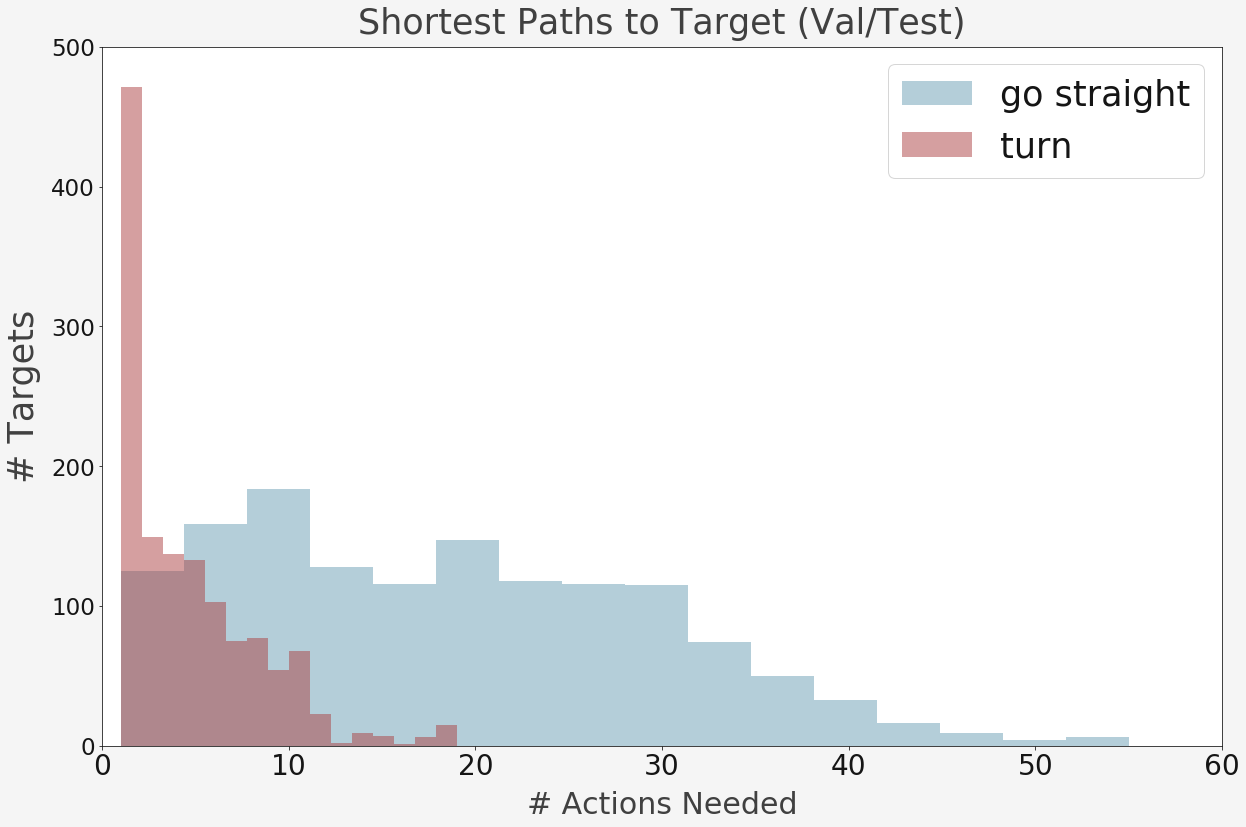

In [60]:
n_bins = 16
plt.hist(action_seq_df['go straight'], bins=n_bins, alpha=0.5, label='go straight')
plt.hist(action_seq_df['turn'], bins=n_bins, alpha=0.5, label='turn')
_ = plt.legend(loc='upper right', fontsize=35)

fig_labels = {
    'fig_title': 'Shortest Paths to Target (Val/Test)',
      'x_label': '# Actions Needed',
      'y_label': '# Targets'
}
plt.xlim(0, 60)
plt.ylim(0, 500)
plt.tight_layout(pad=0)
make_standard_fig(_, fig_labels, save=True, outfile='./figures/val_test_shortest_paths_composit.pdf')

In [61]:
scene_names_df[scene_names_df.split == 'train']['name'].to_csv('train_scenes.csv', index=False)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


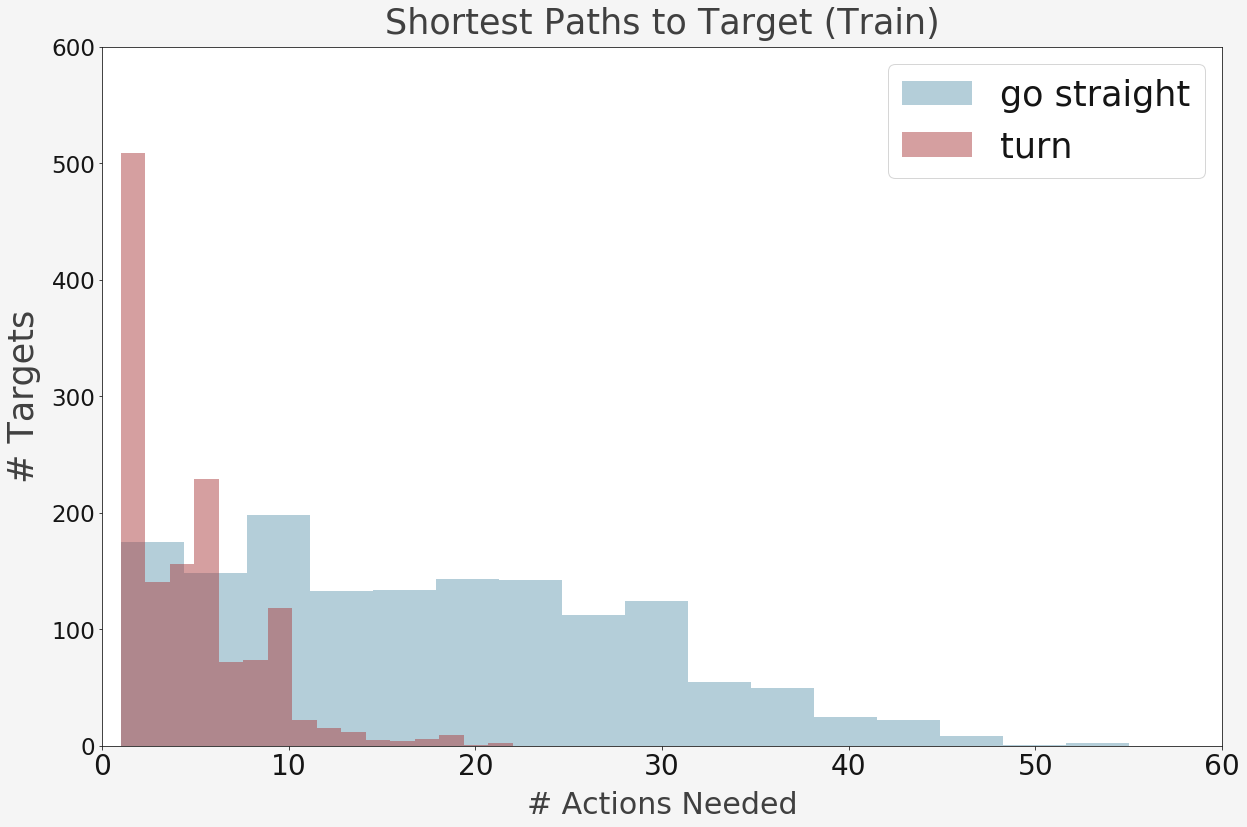

In [65]:
n_bins = 16
plt.hist(action_seq_train_df['go straight'], bins=n_bins, alpha=0.5, label='go straight')
plt.hist(action_seq_train_df['turn'], bins=n_bins, alpha=0.5, label='turn')
_ = plt.legend(loc='upper right', fontsize=35)

fig_labels = {
    'fig_title': 'Shortest Paths to Target (Train)',
      'x_label': '# Actions Needed',
      'y_label': '# Targets'
}
plt.xlim(0, 60)
plt.ylim(0, 600)
plt.tight_layout(pad=0)
make_standard_fig(_, fig_labels, save=True, outfile='./figures/train_shortest_paths_composit.pdf')

In [64]:
# _ = path_len_ser.hist(bins=20)

# fig_labels = {
#     'fig_title': 'Shortest Paths to Target',
#       'x_label': '# Actions Needed',
#       'y_label': '# Targets'
# }
# plt.xlim(0, 70)
# plt.ylim(0, 170)
# make_standard_fig(_, fig_labels, save=True, outfile='./figures/val_test_shortest_paths.pdf')

In [191]:
len(test_sp)

100

In [97]:
scene_1 = 'FloorPlan_RVal2_2'

In [115]:
target_df

,name,objectId,objectType,position,scene,category,role,z,x
17,Television_16,Television|+07.04|+00.79|-02.97,Television,"{'x': 7.04, 'y': 0.785, 'z': -2.967}",FloorPlan_Train10_1,object,target,-2.967,7.040
19,Apple_16,Apple|+01.92|+00.36|-02.97,Apple,"{'x': 1.923, 'y': 0.3554, 'z': -2.969}",FloorPlan_Train10_1,object,target,-2.969,1.923
25,Alarm_Clock_16,AlarmClock|+02.51|+00.48|-04.63,AlarmClock,"{'x': 2.511, 'y': 0.48, 'z': -4.634}",FloorPlan_Train10_1,object,target,-4.634,2.511
26,Mug_1,Mug|+09.36|+00.47|-02.23,Mug,"{'x': 9.36, 'y': 0.47, 'z': -2.23}",FloorPlan_Train10_1,object,target,-2.230,9.360


In [88]:
scene_df = furn_obj_df[furn_obj_df['scene'] == scene_1]
target_df = scene_df[scene_df.role == 'target']

In [113]:
with open('./start_points_val.json') as f:
    val_start_points = json.load(f)['start_points']
    
with open('./start_points_test.json') as f:
    test_start_points = json.load(f)['start_points']

start_point_sets = defaultdict(list)
for p in val_start_points + test_start_points:
    start_point_sets[p['scene']].append(p)

### hide

In [400]:
import random

In [434]:
test_paths = random.sample([format_coords(path) for path in  sppc], 15)

100%|██████████| 15/15 [00:00<00:00, 35.19it/s]


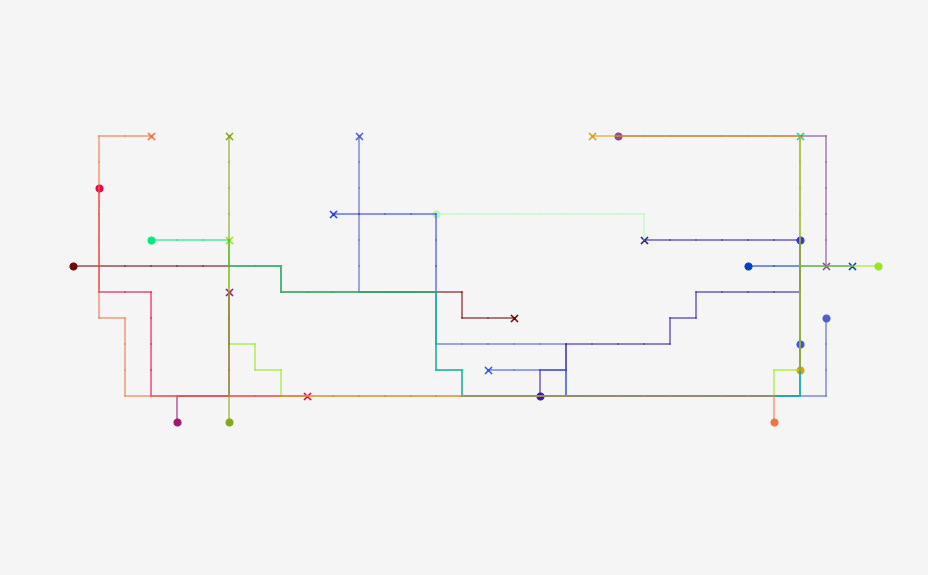

In [435]:
def connectpoints(p1, p2, color):
    x1, x2 = p1['x'], p2['x']
    y1, y2 = p1['y'], p2['y']
    plt.plot([x1, x2], [y1, y2],'k-', color=color, alpha=0.7)

def draw_path(path):
    path_color = np.random.rand(3,)
    prev_point = None
    for cp in path:
        if not prev_point:
            prev_point = cp
            plt.scatter(cp['x'], cp['y'], color=path_color, s=50, marker='x')
        else:
            connectpoints(cp, prev_point, path_color)
            prev_point = cp
    plt.scatter(cp['x'], cp['y'], s=50,color=path_color, marker='o')
    
for path in tqdm(test_paths):
    draw_path(path)
_ = plt.axis('off')
plt.xlim(1, 9.5)
# plt.ylim(-2, -4)
plt.axis('equal')

plt.show()

In [433]:
# 

##  asset counts

In [108]:
def make_standard_fig(fig_plt, fig_labels=None, save = False, outfile='fig.pdf', main_color=None, label_color = '0.25'):
    if fig_labels:
        if 'fig_title' in fig_labels:
            plt.title(fig_labels['fig_title'], fontsize=35, verticalalignment='bottom', color=label_color, y=1.1)
        if 'y_label' in fig_labels:
            plt.ylabel(fig_labels['y_label'], fontsize=35, labelpad=10, color=label_color)
        if 'x_label' in fig_labels:
            plt.xlabel(fig_labels['x_label'], fontsize=30, labelpad=10, color=label_color)
    plt.tick_params(axis='x', which='major', labelsize=28)
    plt.tick_params(axis='y', which='major', labelsize=23)
    if save:
        plt.savefig(outfile, bbox_inches='tight', facecolor=(1, 1, 1, 1))

In [149]:
def make_donut_plot(donut_data, startangle=-40):
    fig, ax = plt.subplots(figsize=(16, 15), subplot_kw=dict(aspect="equal"))

    labels = [f'{count} {c}s' for c, count, in donut_data]

    data = list(zip(*donut_data))[1]

    wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=startangle)

    bbox_props = dict(boxstyle="square, pad=0.1", fc="w", ec="k", lw=0.0)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1) / 2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(labels[i], xy=(x, y), xytext=(1.35 *np.sign(x), 1.3 * y),
                    horizontalalignment=horizontalalignment, **kw, fontsize=25)

#     ax.set_title(title)
    return fig

In [150]:
donut_data

[('Fork', 8),
 ('TennisRacket', 8),
 ('ButterKnife', 7),
 ('Pencil', 9),
 ('Pen', 6),
 ('CellPhone', 10),
 ('Newspaper', 5),
 ('DeskLamp', 12),
 ('SaltShaker', 4),
 ('Candle', 14),
 ('PepperShaker', 4),
 ('Statue', 20),
 ('Lamp', 4),
 ('Pot', 23),
 ('Watch', 2),
 ('Cup', 31),
 ('TeddyBear', 2),
 ('Plate', 32),
 ('CD', 2),
 ('Box', 34),
 ('Glassbottle', 1),
 ('Book', 44)]

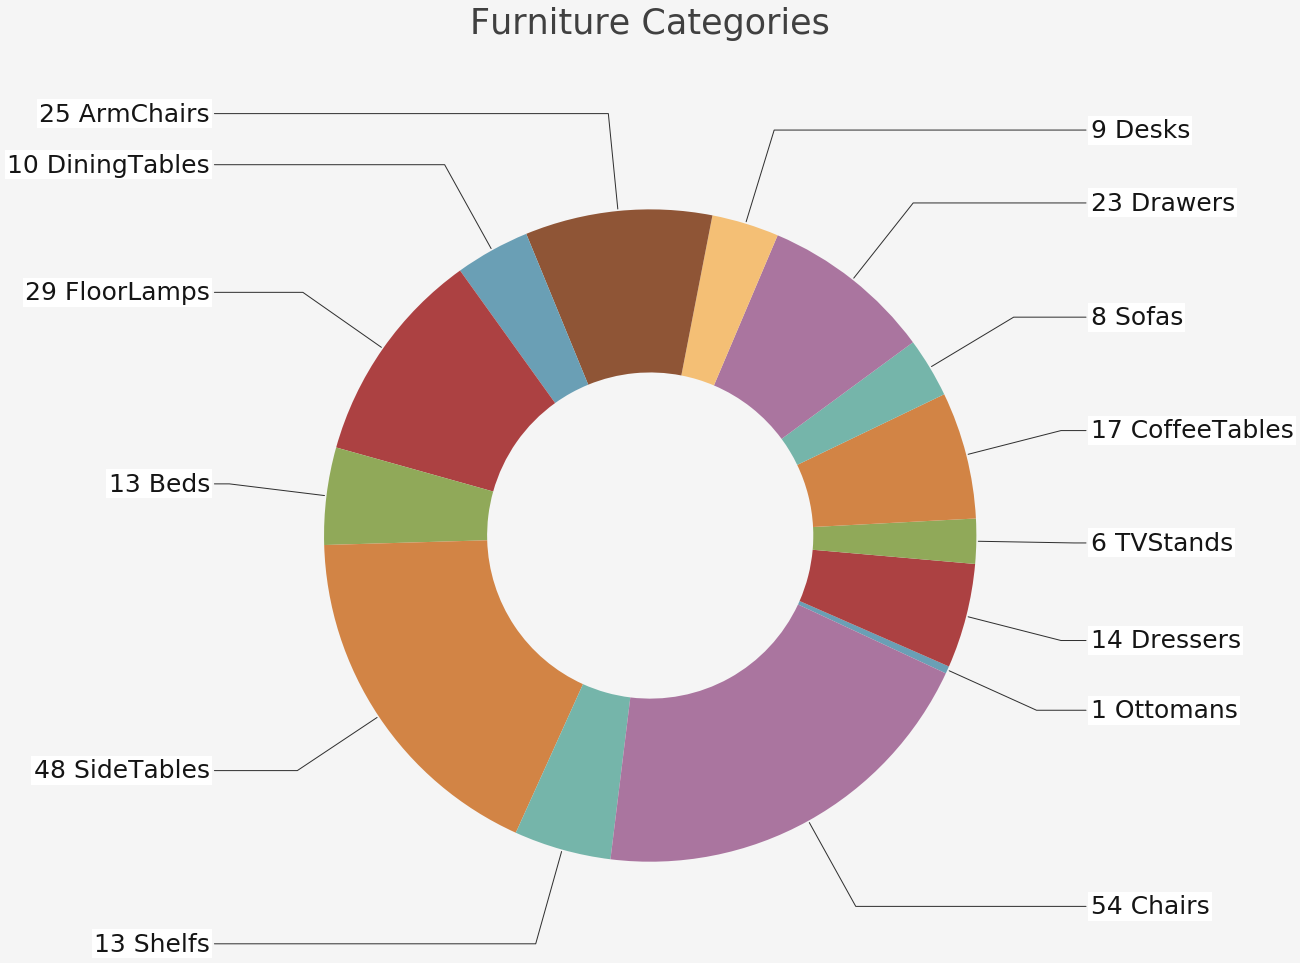

In [174]:
obj_cat_counts = furn_obj_df[furn_obj_df.category == 'furniture'].groupby('objectType')['name'].nunique()
donut_data = list(obj_cat_counts.to_dict().items())
donut_data = sorted(donut_data, key=lambda x: x[1])
donut_data = [val for pair in zip(donut_data[:len(donut_data)//2], donut_data[len(donut_data)//2:]) for val in pair]

fig_labels = {
    'fig_title': 'Furniture Categories',
      'x_label': '',
      'y_label': ''
}

fig_out = make_donut_plot(donut_data, -25)
_ = make_standard_fig(_, fig_labels, save=True, outfile='./figures/furniture_cats.pdf')

In [51]:
import random

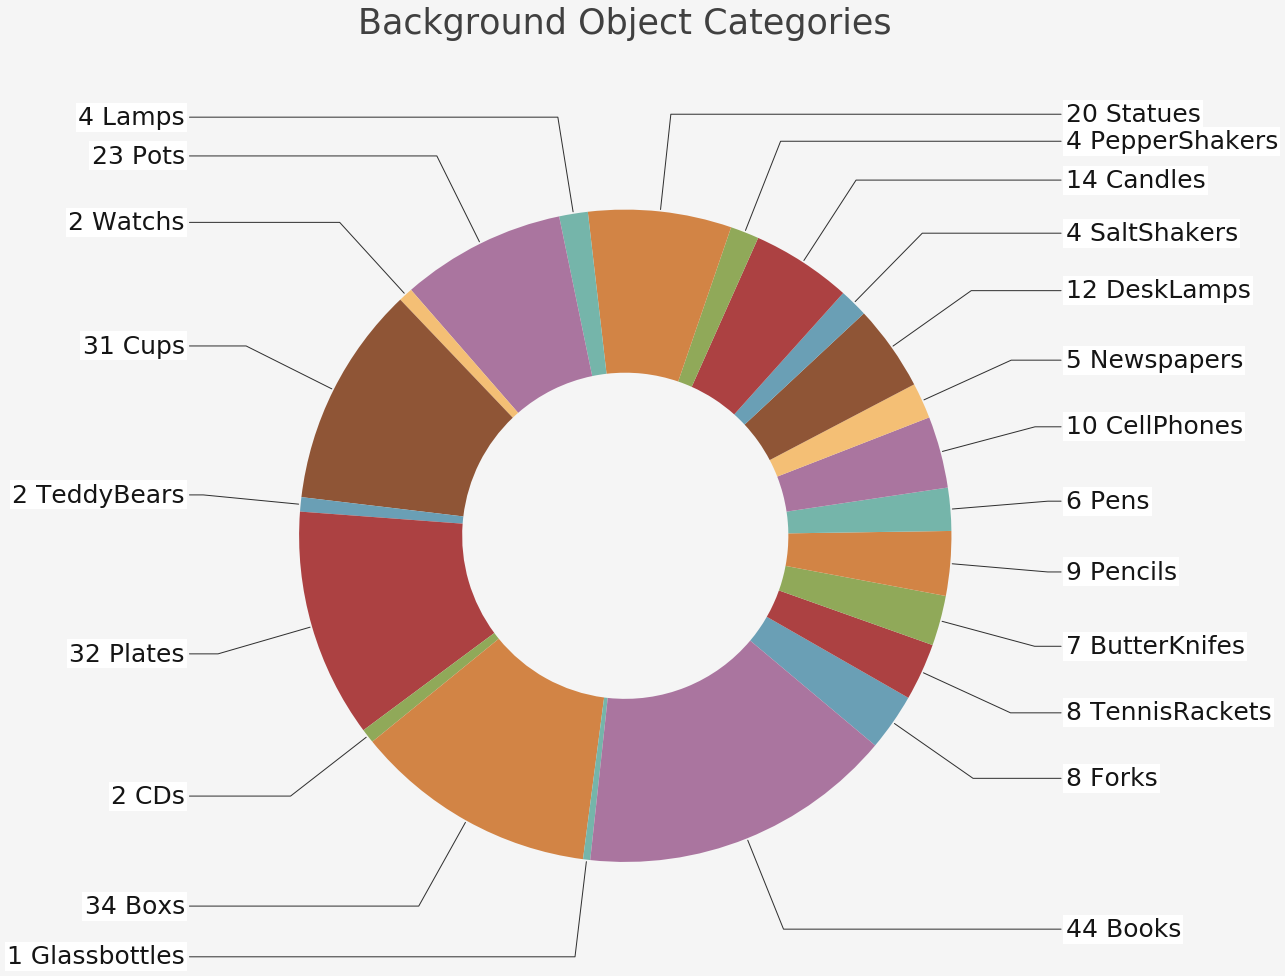

In [168]:
obj_only_df = furn_obj_df[furn_obj_df.category == 'object']
bg_obj_df = obj_only_df[obj_only_df.role == 'background']
obj_cat_counts = bg_obj_df.groupby('objectType')['name'].nunique()
donut_data = list(obj_cat_counts.to_dict().items())
donut_data = sorted(donut_data, key=lambda x: x[1])
donut_data = [val for pair in zip(donut_data[:len(donut_data)//2][::-1], donut_data[len(donut_data)//2:]) for val in pair]

fig_labels = {
    'fig_title': 'Background Object Categories',
      'x_label': '',
      'y_label': ''
}

fig_out = make_donut_plot(donut_data, -40)
_ = make_standard_fig(fig_out, fig_labels, save=True, outfile='./figures/background_cats.pdf')

In [954]:
obj_only_df[obj_only_df['objectType'].str.contains('')].shape

(89, 9)

In [956]:
# obj_only_df[obj_only_df['name'].str.contains('mug')]

In [966]:
obj_cat_counts

objectType
AlarmClock    32
Apple         32
BasketBall     3
Mug            6
Television    32
Name: name, dtype: int64

In [162]:
target_df.shape

(399, 9)

In [165]:
len(donut_data)

5

In [181]:
furn_obj_df.role.value_counts()

background         2233
expanded target     826
target              399
Name: role, dtype: int64

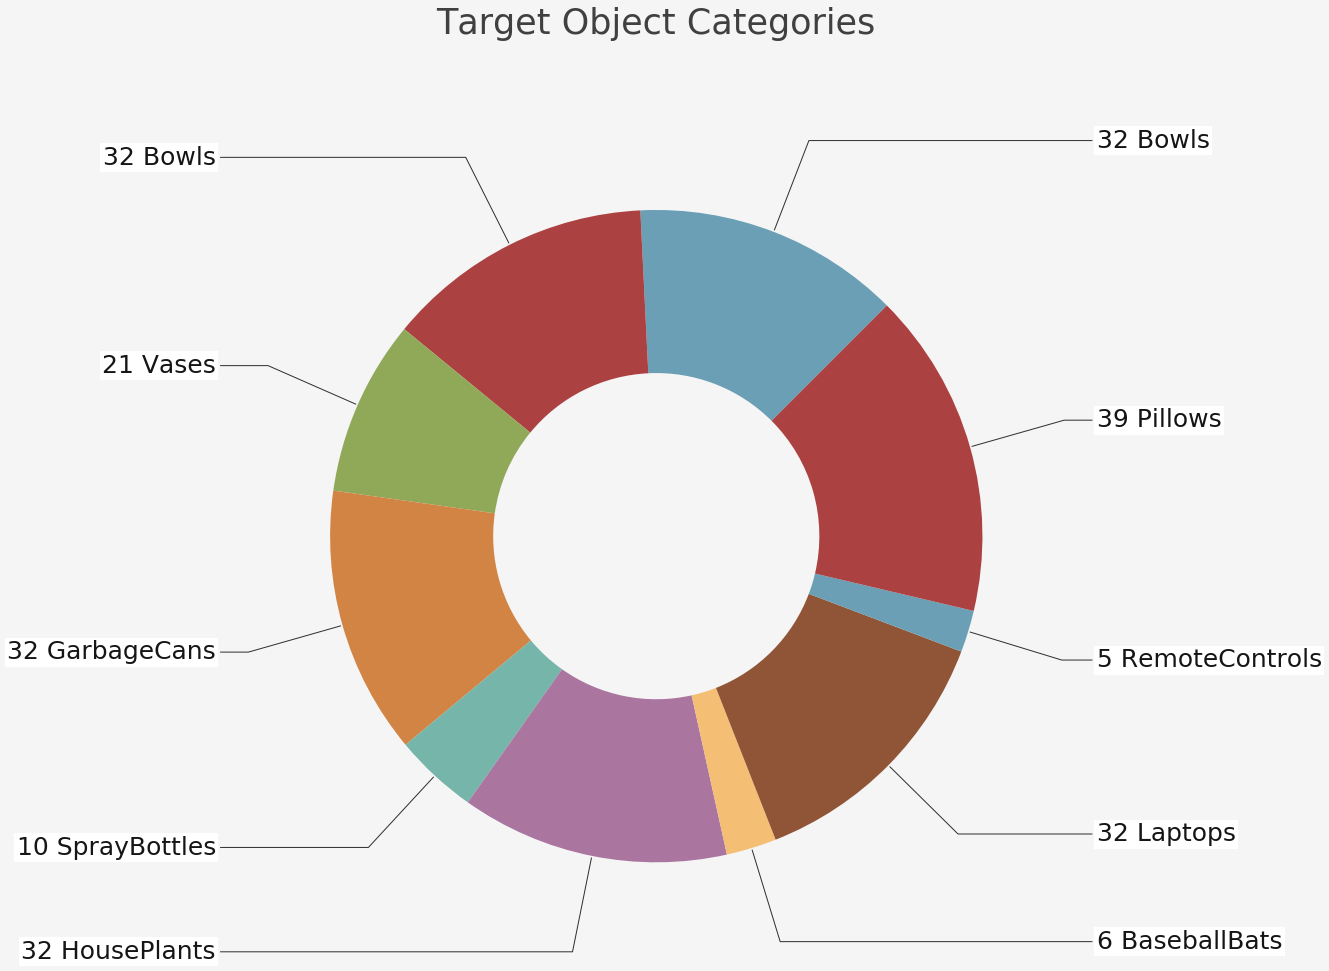

In [183]:
obj_only_df = furn_obj_df[furn_obj_df.category == 'object']
target_df = obj_only_df[obj_only_df.role == 'expanded target']
obj_cat_counts = target_df.groupby('objectType')['name'].nunique()
donut_data = list(obj_cat_counts.to_dict().items())
donut_data = sorted(donut_data, key=lambda x: x[1])
donut_data = [val for pair in zip(donut_data[:len(donut_data)//2 + 1][::-1], donut_data[len(donut_data)//2:]) for val in pair]

fig_labels = {
    'fig_title': 'Target Object Categories',
      'x_label': '',
      'y_label': ''
}


fig_out = make_donut_plot(donut_data, 45)
_ = make_standard_fig(fig_out, fig_labels, save=True, outfile='./figures/target_cats.pdf')

## heatmaps

### objects

In [73]:
def make_heatmap(w_dfm, bin_size=0.3, vmax=20):
    _ = plt.hist2d(w_df.x, w_df.z, bins=[np.arange(1, 10, bin_size), np.arange(-5, -0.8, bin_size)], cmap='viridis')
    _ = plt.axes().set_aspect('equal')
#     _ = plt.colorbar()

In [102]:
multiscene_reachable = {k: v.metadata['actionReturn'] for k, v in  multi_scene_reachable_pos.items()}
build_reachable_df = [p for s in list(multiscene_reachable.values()) for p in s]
reachable_df = pd.DataFrame(build_reachable_df)[['x', 'z']]

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


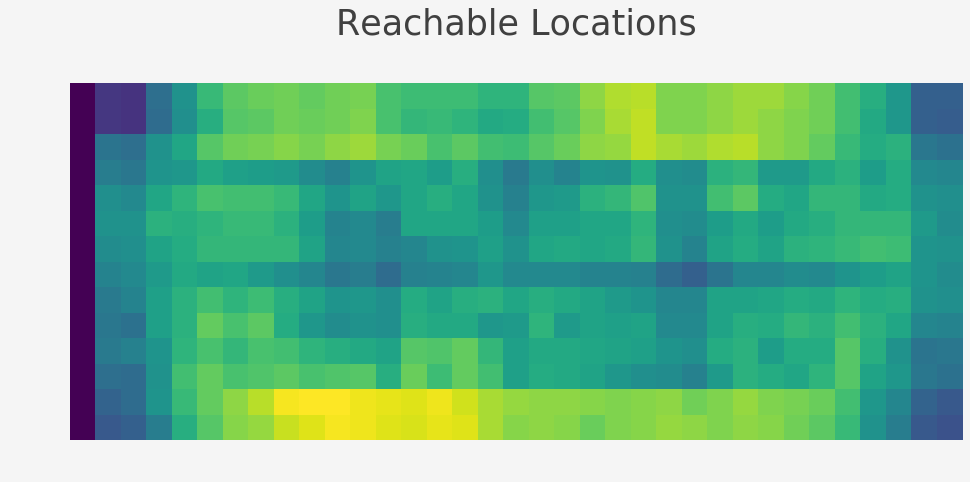

In [176]:
fig_labels = {
    'fig_title': 'Reachable Locations',
      'x_label': '',
      'y_label': ''
}
w_df = reachable_df
make_heatmap(w_df, 0.25, 7)
_ = plt.axis('off')
# plt.xlim(1.25, 8.25)
plt.ylim(-4.5, -1)
make_standard_fig(_, fig_labels, save=True, outfile='./figures/reachable_points.pdf')

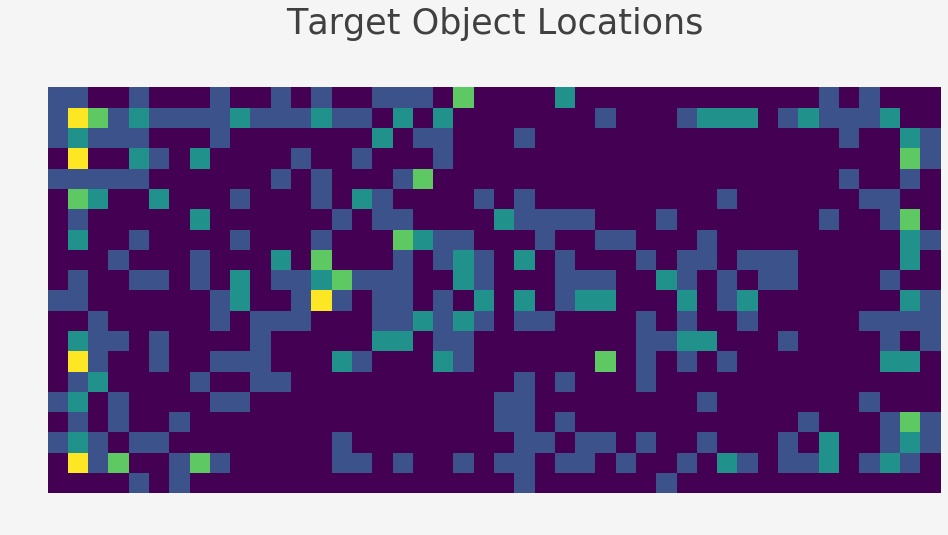

In [177]:
fig_labels = {
    'fig_title': 'Target Object Locations',
      'x_label': '',
      'y_label': ''
}
w_df = furn_obj_df[furn_obj_df.role == 'target']
make_heatmap(w_df, 0.2, 7)
_ = plt.axis('off')
# plt.xlim(1.25, 8.25)
# plt.ylim(-4.50, -1.25)
make_standard_fig(_, fig_labels, save=True, outfile='./figures/target_heatmap.pdf')

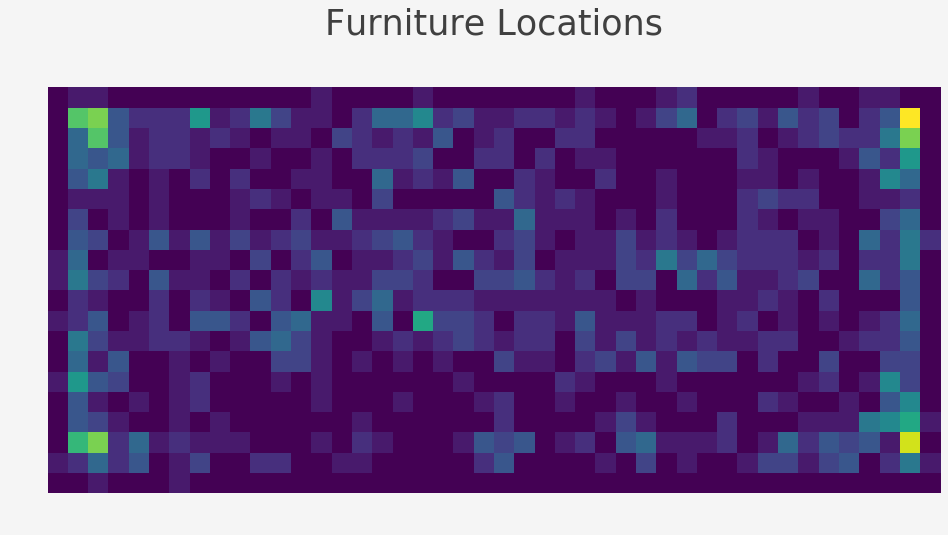

In [178]:
fig_labels = {
    'fig_title': 'Furniture Locations',
      'x_label': '',
      'y_label': ''
}
w_df = furn_obj_df[furn_obj_df.category == 'furniture']
make_heatmap(w_df, 0.2, 7)
# plt.xlim(1.25 , 8.25)
# plt.ylim(-4.50, -1.25)
_ = plt.axis('off')
make_standard_fig(_, fig_labels, save=True, outfile='./figures/furniture_heatmap.pdf')

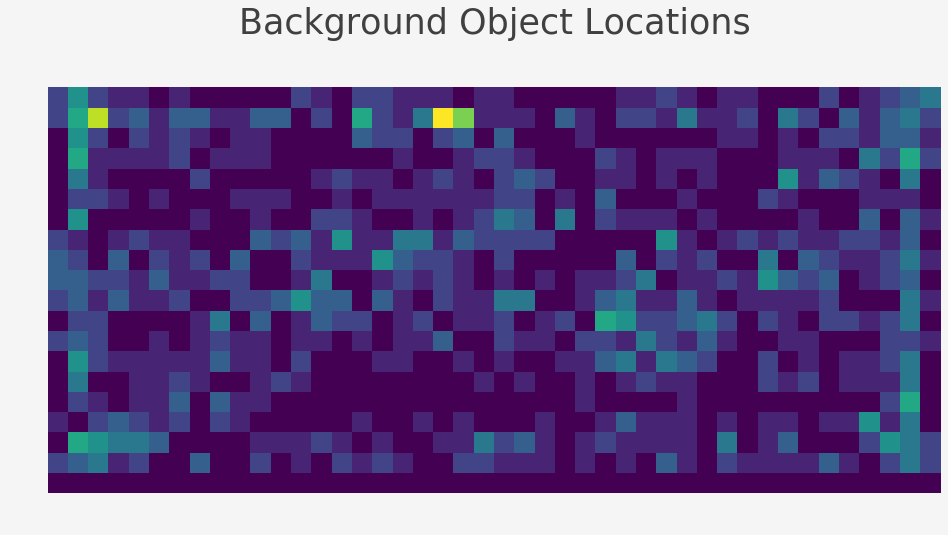

In [179]:
fig_labels = {
    'fig_title': 'Background Object Locations',
      'x_label': '',
      'y_label': ''
}
obj_only_df = furn_obj_df[furn_obj_df.category == 'object']
w_df = obj_only_df[obj_only_df.role == 'background']
make_heatmap(w_df, 0.2, 7)
_ = plt.axis('off')
make_standard_fig(_, fig_labels, save=True, outfile='./figures/background_heatmap.pdf')

### walls

In [92]:
ti = '/Users/schwenk/Downloads/floorplans'

In [94]:
def read_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, threshd = cv2.threshold(img, 253, 255,cv2.THRESH_BINARY)
    threshd = (255 - threshd)
    trim = 50
    h, w = img.shape
    return threshd[trim: h - 120, trim: w - 120]

In [97]:
allfloorplans = os.listdir(ti)

floorplan_images = [read_img(os.path.join(ti, i)) for i in allfloorplans]

fp_arr = np.zeros(floorplan_images[0].shape, np.float)
for im in floorplan_images:
    imarr = np.array(im, dtype=np.float)
    fp_arr = fp_arr + imarr / len(floorplan_images) 
fp_arr = fp_arr * 255 / fp_arr.max()
fp_arr = np.array(np.round(fp_arr), dtype=np.uint8)

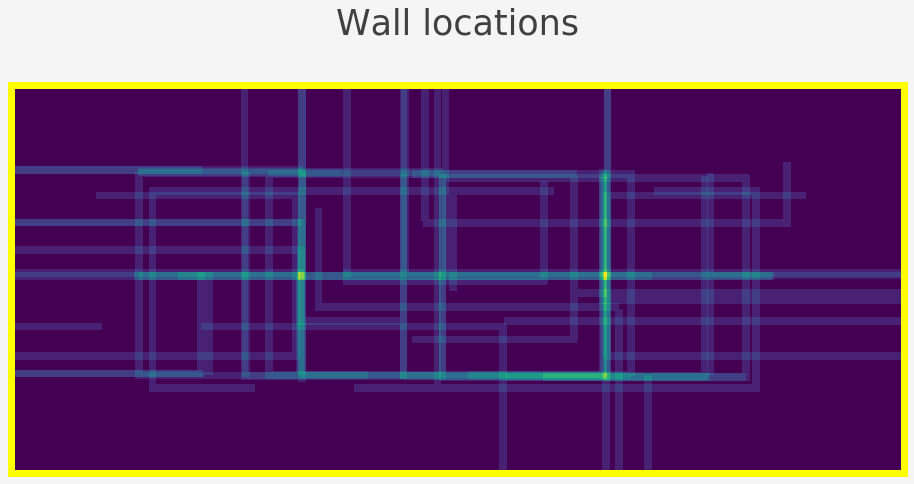

In [180]:
fig_labels = {
    'fig_title': 'Wall locations',
      'x_label': '',
      'y_label': ''
}

cmap = plt.get_cmap('viridis')

rgba_img = cmap(fp_arr)
rgb_img = np.delete(rgba_img, 3, 2)
ax = plt.axes()
_ = ax.set_aspect('equal')
_= plt.imshow(rgb_img)
plt.xticks([])
plt.yticks([])
plt.rcParams["axes.edgecolor"] = "yellow"
plt.rcParams["axes.linewidth"] = 7
make_standard_fig(_, fig_labels, save=True, outfile='./figures/wall_heatmap.pdf')

# Volume 

## # scenes

In [16]:
scene_names_df = pd.read_csv('/Users/schwenk/wrk/transfer/src/ai2thor/scene_list.txt', header=None)
scene_names_df.columns = ['name']

scene_names_df['split'] = scene_names_df.name.str.lower().str.split('_').apply(lambda x: ''.join([i for i in x[1].strip() if not i.isdigit()]))
scene_names_df.name = scene_names_df.name.str.strip()
scene_counts = pd.DataFrame(scene_names_df.split.value_counts())
all_scenes = scene_names_df.name.tolist()
scene_counts

,split
train,75
rtest,10
rval,4
